# Class 8 - Multithreading in Julia

Today we'll talk a bit about Julia's built-in tecniques for taking advantage of multithreading. Note that this notebook makes use of some new features in Julia 1.3.0. If you would like to follow along please install the current release candidate (rc5).

* [Julia's Parallel Documentation](https://docs.julialang.org/en/v1/manual/parallel-computing)

## Getting Started
To get started, launch Julia 1.3.0-rc5 with the command `JULIA_NUM_THREADS=4 [wherever your Julia binary is]` before opening this notebook. On a Mac, after moving the new Julia to the Applications folder the command is `JULIA_NUM_THREADS=4 /Applications/Julia-1.3.app/Contents/Resources/julia/bin/julia`


You can test if this worked by running `Threads.nthreads()`-- the output should be 4.


In [2]:
Threads.nthreads()

4

## Tasks

Before we get started with multithreading, we'll briefly go over Julia's interface for Tasks. A Task is essentially a fully specified function call that we have put aside for later. We can create a `Task` with `@task`.

In [2]:
f() = println("Hello")
function g(x)
    sleep(2)
    println(x)
    return x
end
v = 1
#Examples of tasks
task1 = @task f()
task2 = @task (global v = g("Hello again"))

Task (runnable) @0x000000011c9e3a90

We can check if a task has been started with `istaskstarted()`:

In [3]:
@show istaskstarted(task1)
@show istaskstarted(task2);

istaskstarted(task1) = false
istaskstarted(task2) = false


Finally, we can start a task with `schedule()` and check if it is finished with `istaskdone()`.

In [4]:
schedule(task2);
schedule(task1);
sleep(0.1)
println("Checking if both tasks are started:")
@show istaskstarted(task1)
@show istaskstarted(task2);
sleep(1)
println("Which tasks are done after one second?")
@show istaskdone(task1)
@show istaskdone(task2)
sleep(2)
println("Is task2 done after 2 more seconds?")
@show istaskdone(task2);

Hello
Checking if both tasks are started:
istaskstarted(task1) = true
istaskstarted(task2) = true
Which tasks are done after one second?
istaskdone(task1) = true
istaskdone(task2) = false
Hello again
Is task2 done after 2 more seconds?
istaskdone(task2) = true


If we want to capture the output of a function that we run as a Task, we can alternatively use `fetch()`. Keep in mind that you need to schedule the task before you can fetch it.

In [5]:
task3 = @task(g(1))
schedule(task3)
v = fetch(task3)
@show v

1
v = 1


1

The syntax `@async` conveniently wraps an expression in a Task and schedules it. 

In [6]:
vec = zeros(3)
function h!(v,i)
    sleep(4-i)
    println(i)
    v[i] = i
end
for i = 1:3
    @async h!(vec,i)
end
@show vec;

vec = [0.0, 0.0, 0.0]
3
2
1


In [11]:
rand(1:10)

8

Observe that in the above the vector `vec` is showed before its entries are updated: the `@show` and the calls to `h!` are run asynchronously. If we would like to wait for all asynchronous tasks to complete running before continuing down the code, we can wrap the for loop with the `@sync` macro.

In [8]:
vec = zeros(3)
@sync for i = 1:3
    @async h!(vec,i)
end
@show vec;

3
2
1
vec = [1.0, 2.0, 3.0]


It is important to note that Tasks by themselves all run in a single thread (even when called with `@async`). Thus in compute-bound workloads we do not obtain a performance improvement over not using `Tasks`. However, for network and I/O bound programs scheduling jobs to run asynchronously can give a significant improvement. 

## Exercise 1

This exercise should work in Julia 1.2 .

* Implement [sleep sort](https://www.geeksforgeeks.org/sleep-sort-king-laziness-sorting-sleeping/) using Tasks. 

In [12]:
function sleepstore!(i,out)
    sleep(i)
    push!(out,i)
end

function sleepsort(v)
    out = []
    @sync for i in v
        @async sleepstore!(i,out)
    end
    return out
end

sleepsort([2,5,1,3,4])
#Note that the array "out" is a wrapper around some pointers: array operations are implemented as function calls.
#Thus we can push to it without causing race conditions.

5-element Array{Any,1}:
 1
 2
 3
 4
 5

## Multithreading

### Example: Monte Carlo Simulations

One of the many ways that computers have aided science is through simulation.  Sometimes you may not have a closed-form way to access a quantity of interest, and can obtain a good guess through running many simulations with parameters drawn from a distribution, and looking at the average behavior of your model.  This class of methods is known as [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).  

One of the benefits of Monte Carlo methods is that they are often trivially parallelizable, since you can run independent experiments on separate processes, and then aggregate the results in a single round of communication at the end.

One of the great uses of Monte Carlo methods is [integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration), which becomes increasingly attractive over high-dimensional domains.  The cannonical example is estimating $\pi$ by integrating a circle on a square domian.

The area of a circle with unit radius is $\pi r^2 = \pi$.
The area of a square on $[-1, 1]^2$ is 4.  If we place the unit circle in this square, the ratio of their areas is $\pi/4$.  The idea is that we sample uniformly on this square, and then see what portion of the points lie in the circle.  We know that this ratio should be approximately $\pi/4$, so re multiply the ratio by 4 to obtain our approximation of $\pi$.

Sampling 64 points took 0.00989389419555664 seconds and achieved error -0.2665926535897931
Sampling 128 points took 1.0967254638671875e-5 seconds and achieved error -0.07909265358979312
Sampling 256 points took 7.867813110351562e-6 seconds and achieved error -0.07909265358979312
Sampling 512 points took 2.8848648071289062e-5 seconds and achieved error 0.06934484641020688
Sampling 1024 points took 4.696846008300781e-5 seconds and achieved error -0.016592653589793116
Sampling 2048 points took 9.107589721679688e-5 seconds and achieved error -0.010733278589793116
Sampling 4096 points took 0.00017714500427246094 seconds and achieved error -0.023428591089793116
Sampling 8192 points took 0.00035190582275390625 seconds and achieved error 0.033700315160206884
Sampling 16384 points took 0.0007038116455078125 seconds and achieved error 0.015633908910206884
Sampling 32768 points took 0.001402139663696289 seconds and achieved error 0.009408322972706884
Sampling 65536 points took 0.00280690193176269

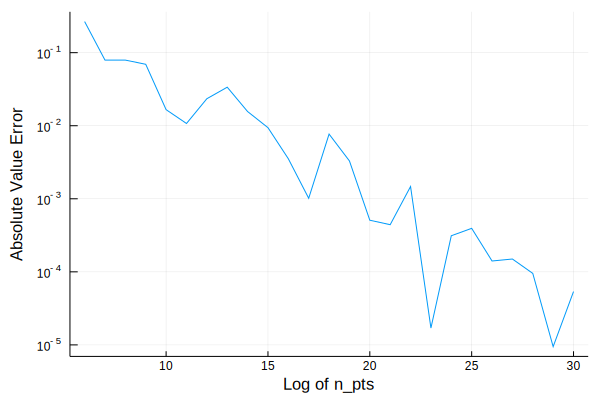

In [13]:
function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

errors = zeros(0)
n_pts = 2 .^collect(6:30) # 2^30 ≈ 1 billion
for n_samples in n_pts
    t1 = time()
    val = π_monte_carlo(n_samples) - π
    push!(errors, val)
    t2 = time()
    println("Sampling $n_samples points took $(t2-t1) seconds and achieved error $val")
end
using Plots
plot(collect(6:30),abs.(errors),yscale=:log10,label="",xlabel="Log of n_pts",ylabel="Absolute Value Error")

It takes us ~25 sec. to estimate $\pi$ on a billion points. However, this used only one core on the machine.  What if we want to use more?  

## Using more than one thread

From the way we started Julia, we know that it has access to four threads right now. However, we need to explicitly use them in our code. The `@spawn` macro creates a Task which Julia will automatically assign to a thread.

In [1]:
import Base.Threads.@spawn

# spawns process that generates a random matrix
m = @spawn randn(2,2)

Task (done) @0x000000011c85aad0

In [16]:
# returns the output from the task
fetch(m)

2×2 Array{Float64,2}:
 0.0847162  -2.79024   
 0.321051   -0.00593942

Observe that Julia will only give us the value of m if we `fetch` it. In the above example our task completed almost immediately. Of course we can also run more intensive computations than this:

In [17]:
function sleep1(x::Int64)
    sleep(x)
    #pretend that sleeping is hard work
    println("Sleep printed $x")
    return 1
end

function awake(x::Int64)
    println("Awake printed $x")
    return 2
end

awake (generic function with 1 method)

In [18]:
out = @spawn sleep1(5)
out2 = @spawn awake(5)
fetch(out) + fetch(out2)

Awake printed 5
Sleep printed 5


3

We see that when two threads do not interact, they return their outputs asynchronously just as we expect. Thus `sleep1` prints second even though it was called first. However unlike with normal `Tasks` using `@spawn` genuinely allocates jobs to different threads: it can give speedups for compute-boundworkloads

Remember that multithreading is only safe if we can ensure that the threads avoid touching the same memory. Thus when controlling the flow of multithreaded code it is sometimes useful to wait for a slow thread to catch up. We can do this by using the `wait` function.

In [19]:
out = @spawn sleep1(5)
out2 = @spawn sleep1(3)
wait(out)
out2 = @spawn awake(5);

Sleep printed 3
Sleep printed 5
Awake printed 5


We can see that this type of threading can give real speedups.

In [20]:
using BenchmarkTools
a = collect(1:10^8)
function add1!(a,first,last)
    for i = first:last
        a[i] = 1+a[i]
    end
    return
end

@benchmark add1!(a,1,10^8)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     114.868 ms (0.00% GC)
  median time:      135.779 ms (0.00% GC)
  mean time:        136.318 ms (0.00% GC)
  maximum time:     147.721 ms (0.00% GC)
  --------------
  samples:          37
  evals/sample:     1

In [21]:
a = collect(1:10^8)
@benchmark begin
t1 = @spawn add1!(a,1,5*10^7)
t2 = @spawn add1!(a,5*10^7+1,10^8)
wait(t1); wait(t2)
end

BenchmarkTools.Trial: 
  memory estimate:  1.44 KiB
  allocs estimate:  18
  --------------
  minimum time:     83.144 ms (0.00% GC)
  median time:      83.838 ms (0.00% GC)
  mean time:        85.524 ms (0.00% GC)
  maximum time:     97.190 ms (0.00% GC)
  --------------
  samples:          59
  evals/sample:     1

A common use case for multithreading is for [embarassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) tasks. As an example, we might want to apply an operation to every element of a vector. We can conveniently do this with `Threads.@threads for`. This macro automatically divides up the range and assigns each chunk to one of the tasks. 

In [22]:
a = collect(1:10)
Threads.@threads for i = 1:10
   println("i = $i on thread $(Threads.threadid())")
    a[i] = Threads.threadid()
end
@show a;

i = 4 on thread 2
i = 1 on thread 1
i = 7 on thread 3
i = 9 on thread 4
i = 8 on thread 3
i = 10 on thread 4
i = 2 on thread 1
i = 5 on thread 2
i = 3 on thread 1
i = 6 on thread 2
a = [1, 1, 1, 2, 2, 2, 3, 3, 4, 4]


With this knowledge in hand, we can write a multithreaded version of our Monte-Carlo calculator for π.

In [38]:
function π_multithreaded1(n_samples::Int64)
    new_n_samples = div(n_samples,Threads.nthreads())
    jobs = []
    out = zeros(Threads.nthreads())
    for i = 1:Threads.nthreads()
        push!(jobs,@spawn π_monte_carlo(new_n_samples))
    end
    for i = 1:Threads.nthreads()
        out[i] = fetch(jobs[i])
    end
    return sum(out)/Threads.nthreads()
end
@time π_multithreaded1(2^29)

  6.342593 seconds (37.97 k allocations: 1.937 MiB)


3.141614407300949

This is a 2.5x speedup! However, the following (plausible looking) code returns the wrong answer.

In [33]:
function π_multithreaded_bad(n_samples::Int64)
    n_circle = 0
    Threads.@threads for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end
@time π_multithreaded_bad(2^20)

  0.126383 seconds (875.64 k allocations: 15.173 MiB)


1.0806503295898438

This is because each thread is trying to update `n_circle`-- the race conditions mean we get the wrong answer. We can fix this by using `Thread.Atomic`s. An atomic is a primitive (numerical) value which Julia will keep track of during multithreaded iteration. If we only do commutative operations to the global `n_circle`, the Atomic will group the operations within a thread and aggregate them at the end.

In [37]:
function π_multithreaded_fixed(n_samples::Int64)
    n_circle = Threads.Atomic{Int}(0)
    Threads.@threads for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            Threads.atomic_add!(n_circle,1)
        end
    end
    return (n_circle.value / n_samples) * 4
end
@time π_multithreaded_fixed(2^25)


  0.890563 seconds (54.51 k allocations: 2.727 MiB)


3.1415563821792603

This implementation is not much faster than the serial one. Although atomics in Julia enable us to use multiple threads, they are unfortunately very slow. We can speed this up by  manually partitioning the interval and performing the aggregation ourselves.

In [36]:
#this should work in Julia 1.2.0
function π_multithreaded_better(n_samples::Int64)
    results = zeros(Threads.nthreads())
    Threads.@threads for tid = 1:Threads.nthreads()
        n_circle = 0
        len = div(n_samples, Threads.nthreads())
        domain = ((tid-1)*len+1):(tid*len)
        for i in domain
            x = rand() * 2 - 1
            y = rand() * 2 - 1
            r2 = x^2 + y^2
            if r2 <= 1
                n_circle += 1
            end
        end
        results[tid] = n_circle
    end
    return (sum(results) / n_samples) * 4
end
@time π_multithreaded_better(2^25)


  0.441603 seconds (63.25 k allocations: 3.108 MiB)


3.1412243843078613

## Exercise 2

* Can you add the `@simd` macro to the for-loop?  How does this compare with parallelization?  Can you mix parallelization and `@simd`?
* Does `@inbounds` have an effect too?

## More Advanced Multithreaded Algorithms

The `Threads.@spawn` interface is extremely versatile and powerful. We can spawn millions of tasks, and so long as we don't care about the order that most computations run in we can reap the benefits of multiple cores while Julia takes care of the rest. Here is an example of a more complicated multithreaded algorithm, taken from [the announcement of the feature](https://julialang.org/blog/2019/07/multithreading).

In [39]:
function mergesort!(v, lo::Int=1, hi::Int=length(v))
    if lo >= hi
        return v
    end
    if hi - lo < 100000
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end
    mid = (lo+hi)>>>1 
    mergesort!(v, lo, mid) 
    mergesort!(v, mid+1, hi)              
    temp = v[lo:mid]            
    i, k, j = 1, lo, mid+1            
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end

    return v
end

mergesort! (generic function with 3 methods)

In [40]:
function psort!(v, lo::Int=1, hi::Int=length(v))
    if lo >= hi                       # 1 or 0 elements; nothing to do
        return v
    end
    if hi - lo < 100000               # below some cutoff, run in serial
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end
    mid = (lo+hi)>>>1                 # find the midpoint

    half = @spawn psort!(v, lo, mid)  # task to sort the lower half; will run
    psort!(v, mid+1, hi)              # in parallel with the current call sorting
                                      # the upper half
    wait(half)                        # wait for the lower half to finish

    temp = v[lo:mid]                  # workspace for merging

    i, k, j = 1, lo, mid+1            # merge the two sorted sub-arrays
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end

    return v
end

psort! (generic function with 3 methods)

In [46]:
x = rand(10^7)
@time mergesort!(x);

  2.535161 seconds (770 allocations: 305.224 MiB, 9.73% gc time)


In [45]:
x = rand(10^7)
@time sort!(x);

  1.488381 seconds (4 allocations: 160 bytes)


In [44]:
x = rand(10^7)
@time psort!(x);

  0.797033 seconds (1.90 k allocations: 305.315 MiB)


Despite the massive memory overhead (due to needing to pass around references to `Tasks`), our parallel sorting implementation outperformed the standard library one!

## Exercise 3

* Below is an implementation of the min-plus product, and a naive parallelization `par_minplus`. Is `par_minplus` faster?
* Modify `par_minplus` to accomodate any number of threads.

In [ ]:
function minplus(a)
    B = zeros(size(a))
    n = size(a)[1]
    for i = 1:n
        for j = 1:n
            value = n+1
            for k = 1:n
                value = min(value,a[i,k] + a[k,j])
            end
            B[i,j] = value
        end
    end
    
    return B
end

function minplus!(a,i_low = 1, i_hi = size(a)[1], B = zeros(size(a)))
    n = size(a)[1]
    for i = i_low:i_hi
        for j = 1:n
            value = n+1
            for k = 1:n
                value = min(value,a[i,k] + a[k,j])
            end
            B[i,j] = value
        end
    end
    return B
end

function par_minplus(a,B=zeros(size(a)))
    quarter_n = div(size(a)[1],4)
    t1 = @spawn minplus!(a,1,quarter_n,B)
    t2 = @spawn minplus!(a,quarter_n+1,2*quarter_n,B)
    t3 = @spawn minplus!(a,2*quarter_n+1,3*quarter_n,B)
    t4 = @spawn minplus!(a,3*quarter_n+1,4*quarter_n,B)
    wait(t1); wait(t2); wait(t3); wait(t4)
    return B
end

A = randn(400,400);

## Locks

As mentioned before, we need to be careful to avoid race conditions when writing multithreaded code. Each thread operates on the same space of memory by default, so if we aren't careful one thread might change something out from under another.

In [6]:
function slow_sum(x)
    sleep(1)
    return sum(x)
end
x = ones(10)
@spawn @show slow_sum(x) #should be 10
@spawn x[1] = 2



Task (done) @0x000000011bcde410

To fix this, we can use a `SpinLock()`.

In [23]:
x = ones(10)
alock = ReentrantLock()
@spawn begin
lock(alock)
println("Thread $(Threads.threadid()) obtained lock")
@show slow_sum(x) #should be 10
println("Thread $(Threads.threadid()) released lock")
unlock(alock)
end
@spawn begin
lock(alock)
println("Thread $(Threads.threadid()) obtained lock")
sleep(0.1)
x[1] = 2
println("Thread $(Threads.threadid()) released lock")
unlock(alock)
end
sleep(2)
@show x[1];

Thread 1 obtained lock
slow_sum(x) = 10.0
Thread 1 released lock
Thread 1 obtained lock
Thread 1 released lock
x[1] = 2.0


There are two types of locks in Julia that are worth mentioning: `SpinLock`s and `ReentrantLock`s. The main difference between the two is that a `SpinLock` can deadlock itself, while a `ReentrantLock` cannot. In code,

In [19]:
alock = ReentrantLock()
begin
lock(alock)
println("Thread $(Threads.threadid()) obtained lock")
lock(alock)
println("Thread $(Threads.threadid()) obtained lock")
println("Thread $(Threads.threadid()) released lock")
unlock(alock)
println("Thread $(Threads.threadid()) released lock")
unlock(alock)
end;
#Thread obtained a lock and tried to obtain it again without unlocking  it first. Julia recognized this and 
#prevented the thread from blocking itself

Thread 1 obtained lock
Thread 1 obtained lock
Thread 1 released lock
Thread 1 released lock


In [3]:
alock = Threads.SpinLock()
@spawn begin
lock(alock)
println("Thread $(Threads.threadid()) obtained lock")
#lock(alock)
#println("Thread $(Threads.threadid()) obtained lock")
#println("Thread $(Threads.threadid()) released lock")
#unlock(alock)
println("Thread $(Threads.threadid()) released lock")
unlock(alock)
end;
#When uncommented, this will kill the thread!

Thread 2 obtained lock
Thread 2 released lock


We can check if a thread is holding a lock with `islocked()`:

In [18]:
alock = ReentrantLock()
@spawn begin
    lock(alock)
    sleep(5)
    unlock(alock)
end
@spawn begin
    sleep(3)
    @show islocked(alock)
    sleep(3)
    @show islocked(alock)
end; 

islocked(alock) = true
islocked(alock) = false


The function `trylock()` attempts to take a lock if it is available. Unlike `lock()`, calling `trylock()` means that the thread will not take the lock when it is available: it only cares if the lock is available in the moment. `trylock()` returns `true` if it succeeds in taking the lock and `false` otherwise.

In [12]:
alock = ReentrantLock()
@spawn begin
    lock(alock)
    sleep(5)
    unlock(alock)
end
@spawn begin
    sleep(3)
    @show a = trylock(alock)
    if a
        unlock(alock) #trylock must be followed by unlock, if it succeeds
        println("Took the lock")
    else
        println("Failed to take lock")
    end
    sleep(3)
    @show a = trylock(alock)
    if a
        unlock(alock) #trylock must be followed by unlock, if it succeeds
        println("Took the lock")
    else
        println("Failed to take lock")
    end
end; 

a = trylock(alock) = false
Failed to take lock
a = trylock(alock) = true
Took the lock


Julia also supports very intricate message-passing schemes amongst `Tasks`, such as semaphore signalling and notifications. We only covered the basics here: if you would like to learn more about this check out the [documentation](https://docs.julialang.org/en/v1.4-dev/base/parallel/#Scheduling-1) or come talk to me after class.

## A couple small optimization tricks for Multithreaded Julia

In Julia, there are two primary ways of obtaining thread safety: locks (which we just covered), and **thread-local state**. Locks are useful to ensure thread safety when the threads don't need to interact very often. However, oftentimes we might want to write code that shares memory amongst threads. We can see this in action in the implementation of `psort!` above:

```julia
function psort!(v, lo::Int=1, hi::Int=length(v))
    if lo >= hi                  
        return v
    end
    if hi - lo < 100000               # below some cutoff, run in serial
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end
    
    mid = (lo+hi)>>>1                 # These are the critical lines for us
    half = @spawn psort!(v, lo, mid)  # 
    psort!(v, mid+1, hi)              # 
    wait(half)                        # 
    temp = v[lo:mid]                  # 

    i, k, j = 1, lo, mid+1            
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end

    return v
end

```

There are two places where we would want to use shared memory in this implementation of Merge Sort. First, we obviously would like our threads to sort the array `v` in place and avoid unnecessary memory allocations. We accomplished thread safety by ensuring that no two `Tasks` ever saw overlapping ranges of the input: this is safe in Julia.

Second and less obviously, we would like to reuse the `temp` array during the recursion. Right now, in every level of the recursion a new `temp` array is defined: eventually a thread will have many spurious `temp` arrays that it no longer needs from lower levels of the recursion. However, this is not obvious to do, as these arrays come from different tasks entirely!

To get around this issue, we utilize the fact that a `Task` can know which thread it is running in. Thus, the Task can write to a *thread's* `temp` array instead of creating a new one from scratch. This reusing of space is known as thread-local state: local variables during a recursion are reused within a thread.

The modifications we need are:

* Change the function signature to 
```julia
function psort!(v, lo::Int=1, hi::Int=length(v), temps=[similar(v, 0) for i = 1:Threads.nthreads()])
```
* Change the recursive calls to `psort!` to use the temporary ranges;
``` julia
half = @spawn psort!(v, lo, mid, temps)
psort!(v, mid+1, hi, temps)
```
* Modify the allocation of the `temp` array to stay within the ranges we defined on each thread
``` julia
temp = temps[Threads.threadid()]
length(temp) < mid-lo+1 && resize!(temp, mid-lo+1)
copyto!(temp, 1, v, lo, mid-lo+1)
```

Plugging these in, we obtain

In [13]:
function psort2!(v, lo::Int=1, hi::Int=length(v), temps=[similar(v, 0) for i = 1:Threads.nthreads()])
    if lo >= hi                  
        return v
    end
    if hi - lo < 100000               # below some cutoff, run in serial
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end
    
    mid = (lo+hi)>>>1                 
    half = @spawn psort2!(v, lo, mid, temps)
    psort2!(v, mid+1, hi, temps)
    wait(half)                         
    temp = temps[Threads.threadid()]
    length(temp) < mid-lo+1 && resize!(temp, mid-lo+1) #fancy way to implement an if-else statement
    copyto!(temp, 1, v, lo, mid-lo+1)                

    i, k, j = 1, lo, mid+1            
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end

    return v
end


psort2! (generic function with 4 methods)

In [17]:
a = rand(10^7)
@time psort2!(a);

  2.348519 seconds (1.68 k allocations: 77.019 MiB)


There is an enormous amount of worked planned on extending the features covered here. The future is looking bright for Julia.

# Thanks for a great quarter!